<a href="https://colab.research.google.com/github/Nilswonderland/Portfolio/blob/main/DL_Assignment_3_(Time_Series_with_RNN_Product_Amount_Forecast_by_Time)_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-3 (RNN)<br><br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)

In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[]

# Indest Data

In [83]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

# Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [84]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [85]:
df.rename(columns = {'IPN31152N':'Production', 'DATE': 'Date'}, inplace = True)


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [87]:
df.isnull().sum()

Production    0
dtype: int64

In [88]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Production,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


In [89]:
df.columns

Index(['Production'], dtype='object')

In [90]:
df.shape

(573, 1)

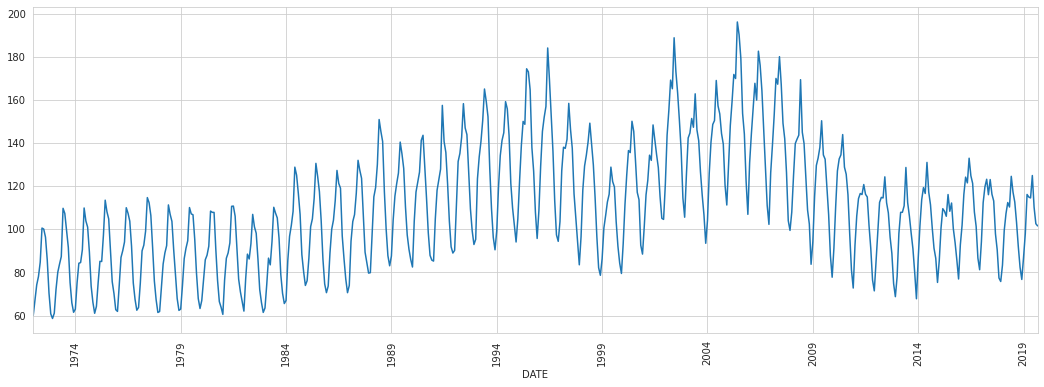

In [91]:
df['Production'].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


# Preprocessing of Data

## Train Test Split

In [94]:
len(df)

573

In [95]:
test_size = 24

In [96]:
test_ind = len(df)- test_size
test_ind

549

In [97]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [98]:
train.shape, test.shape

((549, 1), (24, 1))

## Scaling

In [99]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [100]:
scaler = MinMaxScaler()

In [101]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [102]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [103]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [104]:
X, y = generator[0]

In [106]:
X,y

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]), array([[0.01774221]]))

# Modelling & Model Performance

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [107]:
n_features = train_scaled.shape[1]

## with "tanh" activation function

In [108]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [112]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [113]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [114]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
537/537 [==============================] - 24s 23ms/step - loss: 0.0248 - val_loss: 0.0029
Epoch 2/20
537/537 [==============================] - 10s 19ms/step - loss: 0.0104 - val_loss: 0.0037
Epoch 3/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 4/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 5/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 6/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 7/20
537/537 [==============================] - 10s 19ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 8/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0045 - val_loss: 0.0020


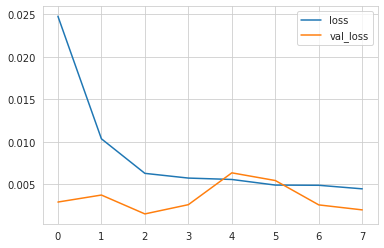

In [115]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [120]:
def evaluation_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [122]:
predictions_scaled = []

first_evaluation_batch = train_scaled[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = model.predict(current_batch)
    predictions_scaled.append(current_pred[0]) 
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [123]:
predictions = scaler.inverse_transform(predictions_scaled)

In [128]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,94.845
2017-11-01,77.438,88.724
2017-12-01,75.812,93.337
2018-01-01,83.434,105.048
2018-02-01,99.490,114.709
2018-03-01,107.315,119.101
2018-04-01,112.431,121.431
2018-05-01,110.354,121.778
2018-06-01,124.584,122.701


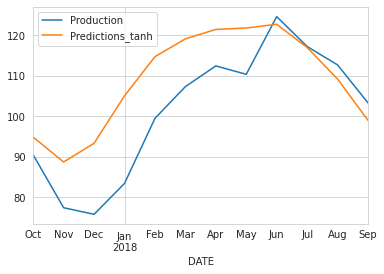

In [129]:
compare.plot()

In [130]:
evaluation_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.45681424180398333 
mae: 9.346355147636183 
mse: 128.09443818749173 
rmse: 11.317881347120217


## with "relu" activation function

In [131]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [132]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [133]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [134]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


537/537 [==============================] - 19s 22ms/step - loss: 0.0329 - val_loss: 0.0062
Epoch 2/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0141 - val_loss: 0.0034
Epoch 3/20
537/537 [==============================] - 9s 18ms/step - loss: 0.0089 - val_loss: 0.0057
Epoch 4/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 5/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 6/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 7/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 8/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 9/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 10/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0062 - val_loss: 0.0060

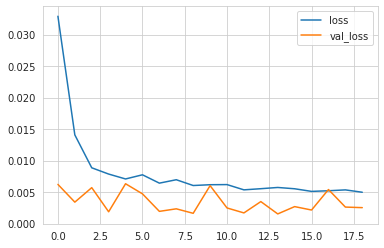

In [135]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [136]:
predictions_scaled = []

first_evaluation_batch = train_scaled[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = model.predict(current_batch)
    predictions_scaled.append(current_pred[0]) 
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [137]:
predictions = scaler.inverse_transform(predictions_scaled)

In [138]:
compare['Predictions_relu'] = predictions
compare

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,94.845,97.645
2017-11-01,77.438,88.724,86.054
2017-12-01,75.812,93.337,85.071
2018-01-01,83.434,105.048,100.310
2018-02-01,99.490,114.709,112.546
2018-03-01,107.315,119.101,117.370
2018-04-01,112.431,121.431,118.988
2018-05-01,110.354,121.778,120.724
2018-06-01,124.584,122.701,123.057


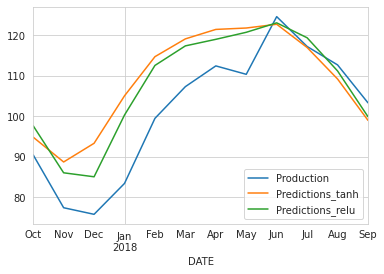

In [139]:
compare.plot()

In [140]:
evaluation_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.6681064477426434 
mae: 7.54606577508946 
mse: 78.26736521158075 
rmse: 8.846884491818617


# Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [141]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [142]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [143]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [144]:
model.fit_generator(generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


561/561 [==============================] - 19s 23ms/step - loss: 0.0276
Epoch 2/10
561/561 [==============================] - 16s 28ms/step - loss: 0.0125
Epoch 3/10
561/561 [==============================] - 15s 27ms/step - loss: 0.0075
Epoch 4/10
561/561 [==============================] - 14s 24ms/step - loss: 0.0076
Epoch 5/10
561/561 [==============================] - 12s 21ms/step - loss: 0.0072
Epoch 6/10
561/561 [==============================] - 10s 18ms/step - loss: 0.0069
Epoch 7/10
561/561 [==============================] - 15s 27ms/step - loss: 0.0061
Epoch 8/10
561/561 [==============================] - 9s 16ms/step - loss: 0.0066
Epoch 9/10
561/561 [==============================] - 10s 17ms/step - loss: 0.0064
Epoch 10/10
561/561 [==============================] - 9s 16ms/step - loss: 0.0064


In [146]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [147]:
forecast = []

first_evaluation_batch = scaled_full_data[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(length):
    
    
    current_pred = model.predict(current_batch)
    forecast.append(current_pred[0]) 
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [148]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 94.35055808],
       [ 82.48187692],
       [ 79.45568182],
       [ 90.20621937],
       [105.12375272],
       [115.46241166],
       [114.93946476],
       [118.02841816],
       [121.26179741],
       [114.06414763],
       [109.00262835],
       [105.5425676 ]])

In [149]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [150]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,94.351
2019-11-01,82.482
2019-12-01,79.456
2020-01-01,90.206
2020-02-01,105.124
2020-03-01,115.462
2020-04-01,114.939
2020-05-01,118.028
2020-06-01,121.262
2020-07-01,114.064


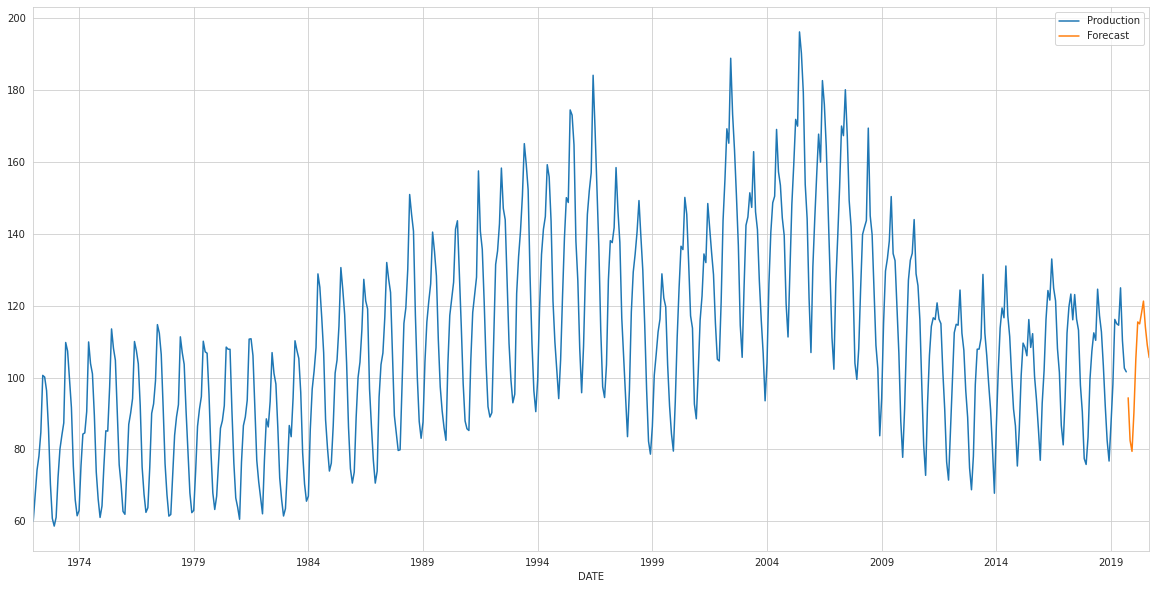

In [156]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize= (20,10));

(600.0, 623.0)

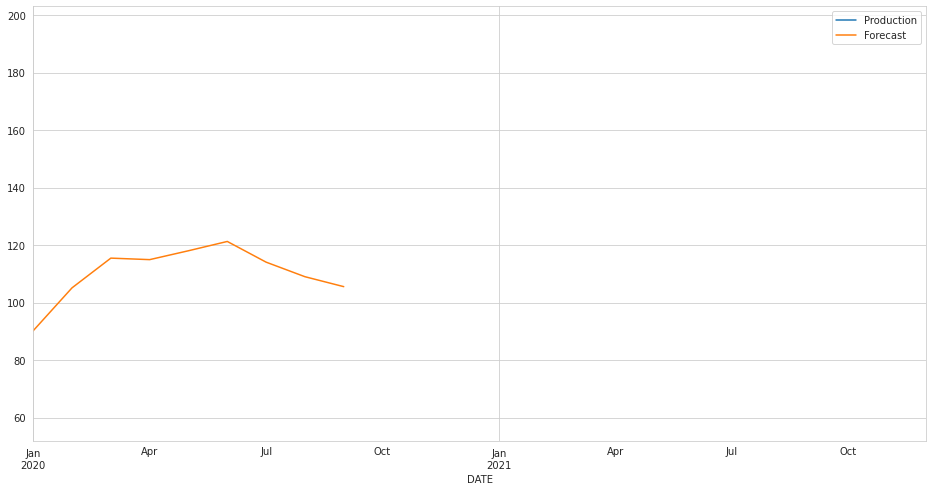

In [158]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2020-01-01', '2021-12-01')

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___